In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
repo_root = "../"
import sys
sys.path.append(repo_root)

In [3]:
import numpy as numpy
import pandas as pd
import xgboost as xgb
import hyperopt as hpt
from preprocessing.country_and_airports_codes import compute_lon_lat,group_and_rename_countries, group_and_rename_airports, group_and_rename_aircraft_types
from preprocessing.encoding import one_hot_encoding,string_to_value_count, string_to_int_hashing
from preprocessing.local_time import add_localtime_to_train_and_test

In [4]:
space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
         'gamma': hpt.hp.uniform('gamma', 0.1, 5),
         'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
         'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
         'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
         'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
         'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
         'subsample': hpt.hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
         'seed': 0}

In [5]:
import os
print(os.getcwd())

/Users/leo/Desktop/Computer_fun/OpenSkyNet/repo3/ATOW_ML/notebooks


In [6]:
train_df = pd.read_csv("../data/challenge_set.csv")
test_df = pd.read_csv("../data/submission_set.csv")

In [8]:
add_localtime_to_train_and_test(train_df,test_df) #add localtime features (departures & arrival hours, day of years, weeks, month)
compute_lon_lat(train_df, test_df) # computes lon, lat for each airport
group_and_rename_countries(train_df, test_df) # simplify country_codes by group and rename countries
group_and_rename_airports(train_df, test_df) # simplify airport codes by group and rename airport
group_and_rename_aircraft_types(train_df, test_df) #regroup less used airlines and create "XXXX" category for unknown ones.


----------------------------------------------------------------------------------------------------
Columns for lon & lat: ['lon_adep', 'lat_adep', 'lon_ades', 'lat_ades'] successfully created !
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Country codes successfully grouped ! Different codes left : 47
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Airports codes successfully grouped ! Different codes left : 155
----------------------------------------------------------------------------------------------------


In [9]:
# encoding

columns_to_ohe = ['aircraft_type'] # A changer
train_df, test_df = one_hot_encoding(train_df, test_df, columns_to_ohe)

columns_to_hash = ['callsign','country_code_ades', 'country_code_adep', 'adep', 'ades', 'airline','wtc'] # A changer
string_to_int_hashing(train_df, test_df, columns_to_hash)

columns_to_vc = [] # A changer
string_to_value_count(train_df, test_df, columns_to_vc)


----------------------------------------------------------------------------------------------------
Columns ['aircraft_type'] sucessfully one hot encoded !
----------------------------------------------------------------------------------------------------
        flight_id        date  callsign  adep               name_adep  \
0       248753821  2022-01-01      2495    92  Istanbul Sabiha Gokcen   
1       248753822  2022-01-01      9518     1                Brussels   
2       248754498  2022-01-01      1902    50                   Miami   
3       248763650  2022-01-01      2259     1                Brussels   
4       248763651  2022-01-01     10029    89                  Zurich   
...           ...         ...       ...   ...                     ...   
158144  258068876  2022-12-31      8596    93            iGA Istanbul   
158145  258064675  2022-12-31        35    23               Amsterdam   
158146  258065436  2022-12-31      5684    58               Barcelona   
158147  2580

In [10]:
# drop unusefull column:
to_drop = ['flight_id','date','name_adep','name_ades','name_adep','actual_offblock_time','arrival_time','local_departure_time','local_arrival_time']
train_df = train_df.drop(columns= to_drop)
test_df = test_df.drop(columns= to_drop)

In [11]:
X = train_df.drop(columns=['tow'])
y = train_df['tow']

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)


print(y_test)

display(X_train)

Train shape:  (295210, 38)
Test shape:  (73803, 38)
360642     78793.000000
362899    161373.000000
29041      59859.000000
27883      46853.000000
198546     59827.152595
              ...      
204954    220632.000000
42079      70694.000000
141949    188305.000000
158625     20944.000000
3440       57851.000000
Name: tow, Length: 73803, dtype: float64


,callsign,adep,country_code_adep,ades,country_code_ades,wtc,airline,flight_duration,taxiout_time,flown_distance,...,aircraft_type_B738,aircraft_type_B772,aircraft_type_B773,aircraft_type_B77W,aircraft_type_B788,aircraft_type_B789,aircraft_type_BCS3,aircraft_type_CRJ9,aircraft_type_E195,aircraft_type_XXXX
217511,5530,115,11,142,20,1,6,137,5,921,...,False,False,False,False,False,False,False,False,False,False
138479,9756,140,19,38,23,1,18,117,5,744,...,False,False,False,False,False,False,False,False,False,False
249849,10501,19,11,30,18,1,20,59,25,333,...,False,False,False,False,False,False,False,False,False,False
247970,7688,82,0,74,10,1,13,133,8,927,...,False,False,False,False,False,False,False,False,False,False
218954,10649,93,45,68,3,1,14,66,16,307,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,9738,91,45,115,51,1,14,57,10,289,...,False,False,False,False,False,False,False,False,False,False
358083,4699,0,1,135,10,1,27,130,5,861,...,False,False,False,False,False,False,False,False,True,False
152315,6817,67,10,29,18,1,20,79,19,460,...,False,False,False,False,False,False,False,False,False,False
117952,1631,104,12,37,23,1,18,230,20,1544,...,False,False,False,False,False,False,False,False,False,False


In [12]:
def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            enable_categorical=True,
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(X_train, y_train), (X_test, y_test)]

    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(X_test)

    score = root_mean_squared_error(y_test, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}

trials = hpt.Trials()
best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100, trials=trials)

SCORE:                                                 
3412.1325330908403                                     
SCORE:                                                                           
4647.212547716925                                                                
SCORE:                                                                           
3977.1583150583424                                                               
SCORE:                                                                           
3729.691065756213                                                                
SCORE:                                                                           
3299.14660270294                                                                 
SCORE:                                                                           
3903.5422101766208                                                             
SCORE:                                                                

In [13]:
display(best)

{'colsample_bytree': 0.7144091985053936,
 'gamma': 3.0449526985116977,
 'learning_rate': 0.15076046065805557,
 'max_depth': 10.0,
 'min_child_weight': 2.0,
 'n_estimators': 726.0,
 'reg_alpha': 1.9697554613212738,
 'reg_lambda': 3.193995094079186,
 'subsample': 0.9737281627808378}

In [14]:
# train xgboost with best hyperparameters

clf = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                        max_depth=int(best['max_depth']),
                        gamma=best['gamma'],
                        reg_alpha=best['reg_alpha'],
                        reg_lambda=best['reg_lambda'],
                        learning_rate=best['learning_rate'],
                        min_child_weight=best['min_child_weight'],
                        subsample=best['subsample'],
                        colsample_bytree=best['colsample_bytree'],
                        seed=0,
                        objective="reg:squarederror",
                        eval_metric="rmse",
                        early_stopping_rounds=10,
                        n_jobs=-1)

eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# predict on test set

y_pred = clf.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)

display(y_pred)
print("SCORE: ", score)

[0]	validation_0-rmse:46023.49445	validation_1-rmse:46001.57902
[1]	validation_0-rmse:39223.59313	validation_1-rmse:39198.63835
[2]	validation_0-rmse:33637.58378	validation_1-rmse:33609.96986
[3]	validation_0-rmse:28825.23746	validation_1-rmse:28795.26498
[4]	validation_0-rmse:24649.19751	validation_1-rmse:24621.91274
[5]	validation_0-rmse:21109.48781	validation_1-rmse:21078.57960
[6]	validation_0-rmse:18124.23708	validation_1-rmse:18098.00261
[7]	validation_0-rmse:15614.39615	validation_1-rmse:15591.16416
[8]	validation_0-rmse:13504.32151	validation_1-rmse:13486.85168
[9]	validation_0-rmse:11721.84745	validation_1-rmse:11708.44705
[10]	validation_0-rmse:10242.31164	validation_1-rmse:10237.71639
[11]	validation_0-rmse:9043.77273	validation_1-rmse:9049.10319
[12]	validation_0-rmse:8068.43655	validation_1-rmse:8079.87714
[13]	validation_0-rmse:7222.27073	validation_1-rmse:7247.22603
[14]	validation_0-rmse:6533.64420	validation_1-rmse:6572.51163
[15]	validation_0-rmse:5974.93475	validatio

array([ 77805.695, 167831.81 ,  62435.992, ..., 180286.34 ,  19822.201,
        54496.35 ], dtype=float32)

SCORE:  3178.010604761587


In [15]:
# compute the root mean squared error

print("RMSE: ", score)

RMSE:  3178.010604761587


Average relative error: 0.027503763606102485
Average absolute error: 2013.8110928862466


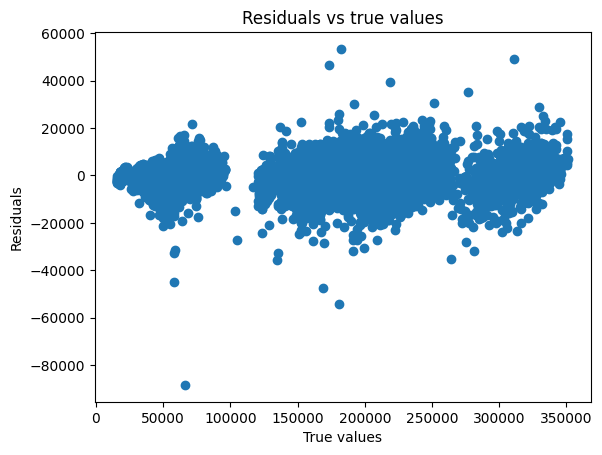

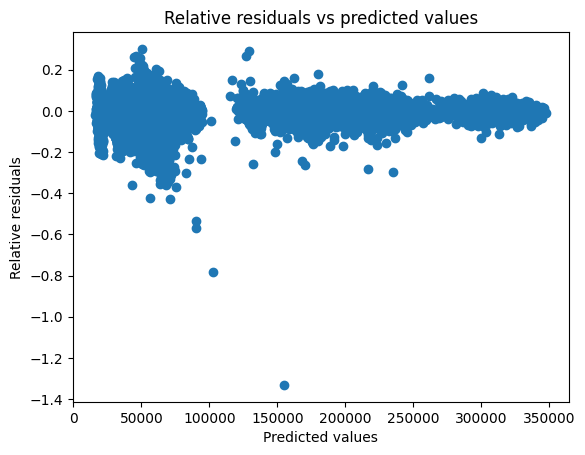

In [16]:
import matplotlib.pyplot as plt

# compute average relative error

relative_error = abs(y_test - y_pred) / y_test

average_relative_error = relative_error.mean()

print(f"Average relative error: {average_relative_error}")

# compute average absolute error

absolute_error = abs(y_test - y_pred)

average_absolute_error = absolute_error.mean()

print(f"Average absolute error: {average_absolute_error}")

# plot residuals vs true values

plt.scatter(y_test, (y_test-y_pred))

plt.xlabel("True values")

plt.ylabel("Residuals")

plt.title("Residuals vs true values")

plt.show()

# plot residuals vs predicted values

plt.scatter(y_pred, (y_test-y_pred)/y_test)

plt.xlabel("Predicted values")

plt.ylabel("Relative residuals")

plt.title("Relative residuals vs predicted values")

plt.show()



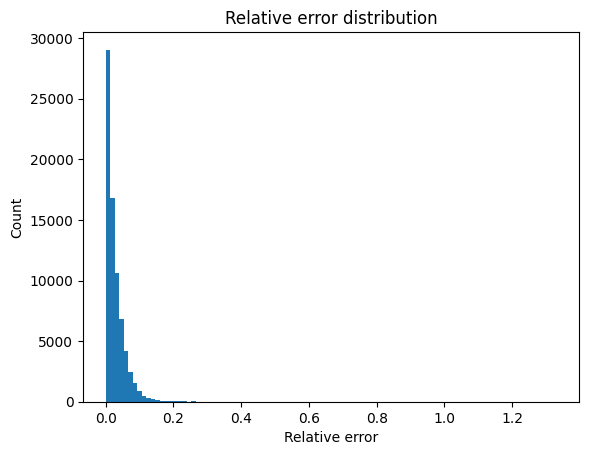

In [17]:
#plot relative error distribution

plt.hist(relative_error, bins=100)

plt.xlabel("Relative error")

plt.ylabel("Count")

plt.title("Relative error distribution")

plt.show()

# plot absolute error distribution

In [18]:
print(relative_error.mean())

0.027503763606102485


In [ ]:
# same optimization on retriced set wtc = 1

x_train_wtc1 = X_train[X_train['wtc'] == 1]

y_train_wtc1 = y_train[X_train['wtc'] == 1]

x_test_wtc1 = X_test[X_test['wtc'] == 1]

y_test_wtc1 = y_test[X_test['wtc'] == 1]

space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
            'gamma': hpt.hp.uniform('gamma', 0.1, 5),
            'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
            'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
            'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
            'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
            'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hpt.hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
            'seed': 0}

def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(x_train_wtc1, y_train_wtc1), (x_test_wtc1, y_test_wtc1)]

    clf.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(x_test_wtc1)

    score = root_mean_squared_error(y_test_wtc1, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}


trials = hpt.Trials()

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=20, trials=trials)

display(best)

In [ ]:
# train xgboost with best hyperparameters

clf_wtc1 = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            learning_rate=best['learning_rate'],
                            min_child_weight=best['min_child_weight'],
                            subsample=best['subsample'],
                            colsample_bytree=best['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)

eval_set = [(x_train_wtc1, y_train_wtc1), (x_test_wtc1, y_test_wtc1)]

clf_wtc1.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=True)

# predict on test set

y_pred_wtc1 = clf_wtc1.predict(x_test_wtc1)

score = root_mean_squared_error(y_pred_wtc1, y_test_wtc1)
                       

In [ ]:
# same optimization on retriced set wtc = 0

x_train_wtc0 = X_train[X_train['wtc'] == 0]

y_train_wtc0 = y_train[X_train['wtc'] == 0]

x_test_wtc0 = X_test[X_test['wtc'] == 0]

y_test_wtc0 = y_test[X_test['wtc'] == 0]

space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
            'gamma': hpt.hp.uniform('gamma', 0.1, 5),
            'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
            'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
            'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
            'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
            'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hpt.hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
            'seed': 0}

def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(x_train_wtc0, y_train_wtc0), (x_test_wtc0, y_test_wtc0)]

    clf.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(x_test_wtc0)

    score = root_mean_squared_error(y_test_wtc0, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}


trials = hpt.Trials()

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100, trials=trials)

display(best)

In [ ]:
# train xgboost with best hyperparameters

clf_wtc0 = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            learning_rate=best['learning_rate'],
                            min_child_weight=best['min_child_weight'],
                            subsample=best['subsample'],
                            colsample_bytree=best['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)

eval_set = [(x_train_wtc0, y_train_wtc0), (x_test_wtc0, y_test_wtc0)]

clf_wtc0.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=True)

# predict on test set

y_pred_wtc0 = clf_wtc0.predict(x_test_wtc0)

score = root_mean_squared_error(y_pred_wtc0, y_test_wtc0)

# compute the root mean squared error

print("RMSE: ", score)

In [ ]:
y_pred_wtc0 = clf_wtc0.predict(X_test)

y_pred_wtc1 = clf_wtc1.predict(X_test)

y_pred = clf.predict(X_test)

y_pred_aggregate = (y_pred_wtc0 * (X_test['wtc'] == 0) + y_pred_wtc1 * (X_test['wtc'] == 1) + y_pred)/2

In [ ]:
# compute the root mean squared error

score = root_mean_squared_error(y_pred_aggregate, y_test)
print("RMSE: ", score)

In [ ]:
# plot residuals vs true values

plt.scatter(y_test, (y_test-y_pred_aggregate))

plt.xlabel("True values")

plt.ylabel("Residuals")

plt.title("Residuals vs true values")

plt.show()

# plot relative error vs true values

plt.scatter(y_test, (y_test-y_pred_aggregate)/y_test)

plt.xlabel("True values")

plt.ylabel("Relative residuals")

plt.title("Relative residuals vs true values")

plt.show()



In [ ]:
# plot relative error distribution

plt.hist(abs(y_test - y_pred_aggregate) / y_test, bins=100)

plt.xlabel("Relative error")

plt.ylabel("Count")

plt.title("Relative error distribution")

plt.show()



In [ ]:
# print average relative error

relative_error = abs(y_test - y_pred_aggregate) / y_test

average_relative_error = relative_error.mean()

print(f"Average relative error: {average_relative_error}")

# print average absolute error

absolute_error = abs(y_test - y_pred_aggregate)

average_absolute_error = absolute_error.mean()

print(f"Average absolute error: {average_absolute_error}")

seuil = 0.05

print(f"Percentage of predictions with relative error below {seuil}: {100 * (relative_error < seuil).mean()}")

print(f"Percentage of predictions with relative error below {2*seuil}: {100 * (relative_error < 2*seuil).mean()}")

print(f"Percentage of predictions with relative error below {3*seuil}: {100 * (relative_error < 3*seuil).mean()}")

In [ ]:
# retrain the model on all the dataset without early stopping

basic_param = {'colsample_bytree': 0.9362150768343058,
 'gamma': 2.022211195429398,
 'learning_rate': 0.07900609044575752,
 'max_depth': 10.0,
 'min_child_weight': 1.0,
 'n_estimators': 862.0,
 'reg_alpha': 1.6659492680583492,
 'reg_lambda': 4.4589665080717085,
 'subsample': 0.7470405034939882}

clf = xgb.XGBRegressor(n_estimators=int(basic_param['n_estimators']),
                            max_depth=int(basic_param['max_depth']),
                            gamma=basic_param['gamma'],
                            reg_alpha=basic_param['reg_alpha'],
                            reg_lambda=basic_param['reg_lambda'],
                            learning_rate=basic_param['learning_rate'],
                            min_child_weight=basic_param['min_child_weight'],
                            subsample=basic_param['subsample'],
                            colsample_bytree=basic_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

eval_set = [(X, y)]

clf.fit(X, y, eval_set=eval_set, verbose=False)

wtc0_param = {'colsample_bytree': 0.8497066984064998,
 'gamma': 1.8567356656935454,
 'learning_rate': 0.041891010160377044,
 'max_depth': 9.0,
 'min_child_weight': 8.0,
 'n_estimators': 859.0,
 'reg_alpha': 3.709715865940738,
 'reg_lambda': 1.6089032820385571,
 'subsample': 0.8005286414941816}


clf_wtc0 = xgb.XGBRegressor(n_estimators=int(wtc0_param['n_estimators']),
                            max_depth=int(wtc0_param['max_depth']),
                            gamma=wtc0_param['gamma'],
                            reg_alpha=wtc0_param['reg_alpha'],
                            reg_lambda=wtc0_param['reg_lambda'],
                            learning_rate=wtc0_param['learning_rate'],
                            min_child_weight=wtc0_param['min_child_weight'],
                            subsample=wtc0_param['subsample'],
                            colsample_bytree=wtc0_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

x_train_wtc0 = X[X['wtc'] == 0]

y_train_wtc0 = y[X['wtc'] == 0]

eval_set = [(x_train_wtc0, y_train_wtc0)]

clf_wtc0.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=False)

wtc1_param = {'colsample_bytree': 0.9865346417369687,
 'gamma': 2.311730004603916,
 'learning_rate': 0.1355408626893648,
 'max_depth': 9.0,
 'min_child_weight': 2.0,
 'n_estimators': 890.0,
 'reg_alpha': 2.7683944404030436,
 'reg_lambda': 0.10259397496527922,
 'subsample': 0.6971029355383804}

clf_wtc1 = xgb.XGBRegressor(n_estimators=int(wtc1_param['n_estimators']),
                            max_depth=int(wtc1_param['max_depth']),
                            gamma=wtc1_param['gamma'],
                            reg_alpha=wtc1_param['reg_alpha'],
                            reg_lambda=wtc1_param['reg_lambda'],
                            learning_rate=wtc1_param['learning_rate'],
                            min_child_weight=wtc1_param['min_child_weight'],
                            subsample=wtc1_param['subsample'],
                            colsample_bytree=wtc1_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

x_train_wtc1 = X[X['wtc'] == 1]

y_train_wtc1 = y[X['wtc'] == 1]

eval_set = [(x_train_wtc1, y_train_wtc1)]

clf_wtc1.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=False)



y_pred_wtc0 = clf_wtc0.predict(test_df)

y_pred_wtc1 = clf_wtc1.predict(test_df)

y_pred = clf.predict(test_df)

y_pred_aggregate = (y_pred_wtc0 * (test_df['wtc'] == 0) + y_pred_wtc1 * (test_df['wtc'] == 1) + y_pred)/2





In [ ]:
# plot clf model importance

import matplotlib.pyplot as plt

xgb.plot_importance(clf)

plt.show()

In [ ]:
# add y_pred_aggregate to test_df

test_df['tow'] = y_pred_aggregate

display(test_df)

## MLP with random search

In [24]:
from sklearn import neural_network, model_selection, metrics
import numpy as np

In [27]:
## GridSearch pour réseau de neurones

#Préparation du GridSearch
alpha_range = 10**(np.arange(-6.,0.,1)) #start, stop(excl.), step
n_neurons_range=((10,), (50,), (100,), (10,10), (50,50))
max_iter_range=(10, 50, 100, 200)
parameters={ 'alpha':alpha_range, 'hidden_layer_sizes':n_neurons_range, 'max_iter':max_iter_range}
MLP = neural_network.MLPRegressor(parameters, random_state=1)
randomsearch_MLP = model_selection.RandomizedSearchCV(MLP, parameters, n_jobs=-1)
#Réalisation du GridSearch sur les données
randomsearch_MLP.fit(X_train,y_train)
print("Avec normalisation, meilleur estimateur trouvé:")
print(randomsearch_MLP.best_estimator_)
print(f"Score sur la base de test: {randomsearch_MLP.score(X_test,y_test)}")

# Si on veut en plus regarder les matrices de confusion etc, il faut entraîner le modèle avec les données de best_estimator_:
MLP=neural_network.MLPClassifier(alpha=1e-2, hidden_layer_sizes=(50,50), max_iter=100, random_state=1, verbose=1)  #à remplacer avec nos paramètres
MLP.fit(X_train,y_train)
print("score MLP %.3f" % MLP.score(X_test, y_test) )
metrics.confusion_matrix(y_test, MLP.predict(X_test))

/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/

Avec normalisation, meilleur estimateur trouvé:
MLPRegressor(alpha=0.001, hidden_layer_sizes=(10, 10), random_state=1)
Score sur la base de test: 0.9824219858109015


ValueError: Unknown label type: (array([68875.        , 51862.        , 72707.        , ...,
       63179.41458733, 53775.        , 76676.00909005]),)

In [29]:

MLP1 = neural_network.MLPRegressor(alpha=0.001, hidden_layer_sizes=(10, 10), random_state=1)
MLP1.fit(X_train,y_train)

/Users/leo/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.001, hidden_layer_sizes=(10, 10), random_state=1)

In [31]:
print("score MLP %.3f" % MLP1.score(X_test, y_test) )


y_pred= MLP1.predict(X_test)
metrics.mean_squared_error(y_test, y_pred)

score MLP 0.982


ValueError: continuous is not supported